# Projet Data Mining

In [1]:
import requests
import datetime
import pandas as pd
import numpy as np 
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
from collections import Counter
import copy
from operator import itemgetter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Max length = 2762
Max time = 2760 days 23:00:00


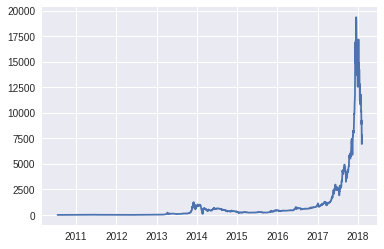

In [2]:
def daily_price_historical(symbol, comparison_symbol, histoday=True, limit=1, aggregate=1, allData='true'):
    # api url
    if histoday:
        url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}&allData={}' \
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData)
    else:
        url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}&allData={}' \
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData)

    # fetch data
    page = requests.get(url)
    data = page.json()['Data']

    # Convert Json to Table
    df = pd.DataFrame(data)

    # add a column with timestamp
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]

    return df


df = daily_price_historical('BTC', 'USD', True)
print('Max length = {}'.format(len(df)))
print('Max time = {}'.format((df.timestamp.max() - df.timestamp.min())))

plt.plot(df.timestamp, df.close)
plt.show()


In [3]:
df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d')
df2 = df.set_index('timestamp')
df2.head(7)

,close,high,low,open,time,volumefrom,volumeto
timestamp,,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,1279324800,20.00,0.9902
2010-07-18,0.08584,0.08585,0.05941,0.04951,1279411200,75.01,5.0900
2010-07-19,0.08080,0.09307,0.07723,0.08584,1279497600,574.00,49.6600
2010-07-20,0.07474,0.08181,0.07426,0.08080,1279584000,262.00,20.5900
2010-07-21,0.07921,0.07921,0.06634,0.07474,1279670400,575.00,42.2600
2010-07-22,0.05050,0.08181,0.05050,0.07921,1279756800,2160.00,129.7800
2010-07-23,0.06262,0.06767,0.05050,0.05050,1279843200,2402.50,141.0700


In [4]:
pa = pd.read_csv('results.csv', usecols=["Date","Value"])
pa['Date'] = [pd.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in pa.Date]
pa = pa.set_index('Date')

In [5]:
rcParams['figure.figsize'] = 15, 6
pa['mean'] = pa.rolling(window=5, center=True).mean()
ts = pa['mean']

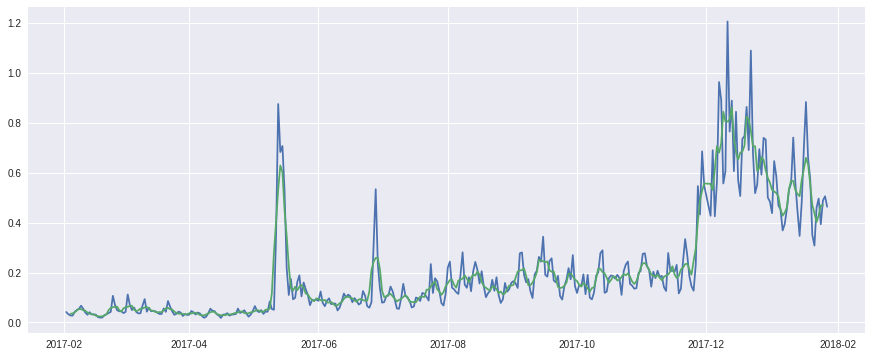

In [6]:
plt.plot(pa)

In [7]:
#on décale la série ts pour ensuite calculer l'écart entre une valeur et la moyenne mobile au temps précédent
for i in range(1,len(ts)) :
    ts[len(ts)-i] = ts[(len(ts)-i)-1]

### (fonction de) Création de la colonne buzz

In [8]:
def buzz(eps_buzz1,eps_buzz2 = False):
    pa['buzz']='c'
    if eps_buzz2 :
        pa['buzz'][((pa['Value']-ts)>eps_buzz1) & ((pa['Value']-ts)<eps_buzz2)]='U'
        pa['buzz'][((pa['Value']-ts)<-eps_buzz1) & ((pa['Value']-ts)>-eps_buzz2)]='D'
        pa['buzz'][(pa['Value']-ts)>eps_buzz2]='u'
        pa['buzz'][(pa['Value']-ts)<-eps_buzz2]='d'
    else :
        pa['buzz'][(pa['Value']-ts)>eps_buzz1]='u'
        pa['buzz'][(pa['Value']-ts)<-eps_buzz1]='d'

In [9]:
buzz(0.05,0.15)

In [10]:
b = (0.05,0.15)
c = [0.1]
buzz(*b)

### Concaténation avec la première table

In [11]:
pa = pa.join(df2)

In [12]:
pa = pa[['open','close','Value','buzz']]

### Affichage des différents buzz/debuzz

In [13]:
pa[pa['buzz']!='c'].head()

,open,close,Value,buzz
Date,,,,
2017-03-03,1255.47,1283.30,0.1121,U
2017-05-11,1752.31,1819.29,0.0508,D
2017-05-12,1819.29,1686.39,0.3512,U
2017-05-13,1686.39,1763.74,0.8747,u
2017-05-14,1763.74,1772.55,0.6825,U


### Création de la variable d'ecart

In [14]:
pa['ecart'] = pa['close']-pa['open']

In [15]:
epsilon1 = 0.005
epsilon2 = 0.1

In [16]:
def variation(epsilon1,epsilon2,epsilon3=False):
    pa['variation'] = 0
    pa['variation'][(pa['ecart']>pa['open']*epsilon1) & (pa['ecart']<pa['open']*epsilon2)] = 1
    pa['variation'][(pa['ecart']<-pa['open']*epsilon1) & (pa['ecart']>-pa['open']*epsilon2)] = -1
    if not epsilon3 :
        pa['variation'][pa['ecart'] < -pa['open']*epsilon2] = -2
        pa['variation'][pa['ecart'] > pa['open']*epsilon2] = 2
    else :
        pa['variation'][(pa['ecart']>pa['open']*epsilon2) & (pa['ecart']<pa['open']*epsilon3)] = 2
        pa['variation'][(pa['ecart']<-pa['open']*epsilon2) & (pa['ecart']>-pa['open']*epsilon3)] = -2
        pa['variation'][pa['ecart'] < -pa['open']*epsilon3] = -3
        pa['variation'][pa['ecart'] > pa['open']*epsilon3] = 3

In [17]:
variation(0.005,0.05,0.1)

In [18]:
pa[abs(pa['variation'])>1].head(10)

,open,close,Value,buzz,ecart,variation
Date,,,,,,
2017-02-09,1055.49,978.96,0.0671,c,-76.53,-2
2017-03-08,1232.69,1146.97,0.0362,c,-85.72,-2
2017-03-10,1191.33,1112.39,0.0681,c,-78.94,-2
2017-03-11,1112.39,1179.22,0.0935,c,66.83,2
2017-03-16,1253.43,1172.88,0.0450,c,-80.55,-2
2017-03-17,1172.88,1071.71,0.0395,c,-101.17,-2
2017-03-18,1071.71,971.38,0.0339,c,-100.33,-2
2017-03-19,971.38,1022.60,0.0342,c,51.22,2
2017-03-21,1047.51,1121.29,0.0425,c,73.78,2


In [19]:
print(sum(pa['variation']==-2))
print(sum(pa['variation']==-1))
print(sum(pa['variation']==0))
print(sum(pa['variation']==1))
print(sum(pa['variation']==2))

35
77
51
137
36


### Fonctions de création des séquences

In [20]:
def sequences(distance_buzz, liste_variation, liste_buzz) :
    seq1 = [liste_variation[i-distance_buzz:(i+distance_buzz+1)] 
            for i in range(len(liste_variation[:-(distance_buzz-1)])) 
            if abs(liste_variation[i])==2]
    seq1 = [list(map(str,s)) for s in seq1]
    
    seq2 = [liste_buzz[i-distance_buzz:(i+distance_buzz+1)] 
            for i in range(len(liste_variation[:-(distance_buzz-1)])) 
            if abs(liste_variation[i])==2]
    
    zipped_list = [list(zip(seq1[i], seq2[i])) for i in range(len(seq1))]
    zipped_list2 = [[list(a[i]) for i in range(len(a))] for a in zipped_list]
    result = [[t  if (t[1]!='c') else [t[0]] for t in s] for s in zipped_list2]
    return result

In [21]:
test_seq = sequences(3,pa['variation'].tolist(),pa['buzz'].tolist())
test_seq

[[['1'], ['1'], ['1'], ['-2'], ['1'], ['1'], ['-1']],
 [['1'], ['0'], ['-1'], ['-2'], ['1'], ['-2'], ['2']],
 [['-1'], ['-2'], ['1'], ['-2'], ['2'], ['1'], ['1']],
 [['-2'], ['1'], ['-2'], ['2'], ['1'], ['1'], ['0']],
 [['1'], ['0'], ['1'], ['-2'], ['-2'], ['-2'], ['2']],
 [['0'], ['1'], ['-2'], ['-2'], ['-2'], ['2'], ['1']],
 [['1'], ['-2'], ['-2'], ['-2'], ['2'], ['1'], ['2']],
 [['-2'], ['-2'], ['-2'], ['2'], ['1'], ['2'], ['-2']],
 [['-2'], ['2'], ['1'], ['2'], ['-2'], ['-1'], ['-2']],
 [['2'], ['1'], ['2'], ['-2'], ['-1'], ['-2'], ['1']],
 [['2'], ['-2'], ['-1'], ['-2'], ['1'], ['0'], ['2']],
 [['-2'], ['1'], ['0'], ['2'], ['0'], ['0'], ['0']],
 [['1'], ['-1'], ['-1'], ['2'], ['0'], ['-1'], ['1']],
 [['-1'], ['1'], ['1'], ['2'], ['1'], ['1'], ['1', 'D']],
 [['1'], ['1'], ['1', 'D'], ['-2', 'U'], ['1', 'u'], ['0', 'U'], ['-1', 'U']],
 [['1'], ['0'], ['1'], ['2', 'U'], ['2'], ['-2'], ['-1']],
 [['0'], ['1'], ['2', 'U'], ['2'], ['-2'], ['-1'], ['-2']],
 [['1'], ['2', 'U'], ['2'], ['-

In [23]:
def sequ_buzz(taille):
    tab = [[pa['variation'].loc[idx],pa['buzz'].loc[idx]] for idx in pa.index]
    return sequences(taille,tab)

#### On écrit la fonction isSubSeq qui renvoie si la séquence sub est sub-séquence de la séquence seq.

### Fonction de test isSubSeq

In [24]:
def isSubSeq(seq,sub) :
    newsub = list(sub)
    return(SubSeq(seq,newsub))

#### On recherche de manière récursive chaque élément de la sous-séquence dans la séquence principale, tout en avançant dans cette dernière sans retour en arrière. Tant que l'on trouve les éléments on continue la recherche. Si il n'y a plus d'éléments à rechercher, c'est bon et on remonte les appels en renvoyant des True. Si l'un des éléments de la sous-séquence potentielle n'a pas été trouvé, False est renvoyé.

In [25]:
def SubSeq(seq,newsub,level=0) :
    if(not newsub):
        return True
    first = set(newsub.pop(0))
    for i in range(level,len(seq)) :
        if set(seq[i]).issuperset(first) : 
            return SubSeq(seq,newsub,i+1)
    return False

In [26]:
test=[['a'],['b','c'],['a']]
test2=[['c'],['b']]
test3=[['a'],['c']]
print(isSubSeq(test,test2))
isSubSeq(test,test3)

False


True

#### fonction de calcul du  support d'une séquence

In [27]:
def support(dict,tested_seq) :
    return sum(1 for seq in dict if isSubSeq(seq,tested_seq)) 

In [28]:
datatest = [test,test2,test3]
support(datatest,['a','c'])

2

## fonction get_cand

### Premiere fonction de création de candidats de taille k à partir de deux seq de taille k-1

#### Version qui concatène les éléments en bout de séquence :

In [29]:
def generateCandidatesForPair(cand1, cand2):
    cand1Clone = copy.deepcopy(cand1)
    cand2Clone = copy.deepcopy(cand2)
    # drop the leftmost item from cand1:
    if (len (cand1[0]) == 1):
        cand1Clone.pop(0)
    else:
        cand1Clone[0] = cand1Clone[0][1:]
    # drop the rightmost item from cand2:
    if (len (cand2[-1]) == 1):
        cand2Clone.pop(-1)
    else:
        cand2Clone[-1] = cand2Clone[-1][:-1]
    
    # if the result is not the same, then we dont need to join
    if not cand1Clone == cand2Clone:
        return []
    else:
        newCandidate = copy.deepcopy(cand1)
        if (len (cand2[-1]) == 1):
            newCandidate.append(cand2[-1])
        else:
            newCandidate[-1].extend(cand2[-1][-1])
        return newCandidate

In [30]:
def sequenceLength(sequence) : 
    return sum(len(seq) for seq in sequence)

#### on génère les candidats avec 

In [31]:
def generateCandidates(lastLevelCandidates,focus_val):
    k = sequenceLength(lastLevelCandidates[0]) + 1
    if (k == 2):
        flatShortCandidates = [item for sublist2 in lastLevelCandidates for sublist1 in sublist2 for item in sublist1]
        candidates = [[[a, b]] for a in flatShortCandidates for b in flatShortCandidates if( b > a and (a in focus_val or b in focus_val))]
    else:
        candidates = []
    for i in range(0, len(lastLevelCandidates)):
        for j in range(0, len(lastLevelCandidates)):
            newCand = generateCandidatesForPair(lastLevelCandidates[i], lastLevelCandidates[j])
            if (not newCand == [] and (True in [ (i in t) for i in focus_val for t in newCand])):
                candidates.append(newCand)
    candidates.sort()
    return candidates

In [32]:
a = range(5)
b = range(1,3)
[i*j for i in a for j in b]

[0, 0, 1, 2, 2, 4, 3, 6, 4, 8]

In [33]:
level_test = [[['a']],[['b']],[['c']],[['d']]]
level_test_2 = generateCandidates(level_test,'a')
print(level_test_2)

[[['a'], ['a']], [['a'], ['b']], [['a'], ['c']], [['a'], ['d']], [['a', 'b']], [['a', 'c']], [['a', 'd']], [['b'], ['a']], [['c'], ['a']], [['d'], ['a']]]


In [34]:
level_test_3 = generateCandidates(level_test_2,'a')
level_test_3

[[['a'], ['a'], ['a']],
 [['a'], ['a'], ['b']],
 [['a'], ['a'], ['c']],
 [['a'], ['a'], ['d']],
 [['a'], ['a', 'b']],
 [['a'], ['a', 'c']],
 [['a'], ['a', 'd']],
 [['a'], ['b'], ['a']],
 [['a'], ['c'], ['a']],
 [['a'], ['d'], ['a']],
 [['a', 'b'], ['a']],
 [['a', 'c'], ['a']],
 [['a', 'd'], ['a']],
 [['b'], ['a'], ['a']],
 [['b'], ['a'], ['b']],
 [['b'], ['a'], ['c']],
 [['b'], ['a'], ['d']],
 [['b'], ['a', 'b']],
 [['b'], ['a', 'c']],
 [['b'], ['a', 'd']],
 [['c'], ['a'], ['a']],
 [['c'], ['a'], ['b']],
 [['c'], ['a'], ['c']],
 [['c'], ['a'], ['d']],
 [['c'], ['a', 'b']],
 [['c'], ['a', 'c']],
 [['c'], ['a', 'd']],
 [['d'], ['a'], ['a']],
 [['d'], ['a'], ['b']],
 [['d'], ['a'], ['c']],
 [['d'], ['a'], ['d']],
 [['d'], ['a', 'b']],
 [['d'], ['a', 'c']],
 [['d'], ['a', 'd']]]

### Fonction de génération des sous-séquences

In [35]:
def generateDirectSubsequences(sequence):
    result = []
    for i, itemset in enumerate(sequence):
        if (len(itemset) == 1):
            sequenceClone = copy.deepcopy(sequence)
            sequenceClone.pop(i)
            result.append(sequenceClone)
        else:
            for j in range(len(itemset)):
                sequenceClone = copy.deepcopy(sequence)
                sequenceClone[i].pop(j)
                result.append(sequenceClone)
    return result

## Algorithme Apriori àproprement parler :

In [36]:
def apriori(dataset, minSupport, focus_value, verbose=False, taillemin = 2,taillemax = 0):
    if taillemax == 0 :
        taillemax = taillemin+1
    global numberOfCountingOperations
    numberOfCountingOperations = 0
    Overall = []
    itemsInDataset = sorted(set ([item for sublist1 in dataset for sublist2 in sublist1 for item in sublist2]))
    singleItemSequences = [[[item]] for item in itemsInDataset]
    singleItemCounts = [(i, support(dataset, i)) for i in singleItemSequences if (support(dataset, i) >= minSupport)]
    Overall.append(singleItemCounts)
    #print("Result, lvl 1: " + str(Overall[0]))
    k = 1
    while (True):
        if not Overall [k - 1]:
            break
        # 1. Candidate generation
        candidatesLastLevel = [x[0] for x in Overall[k - 1]]
        candidatesGenerated = generateCandidates(candidatesLastLevel,focus_value)
        candidatesCounts = [(i, support(dataset, i)) for i in candidatesGenerated]
        resultLvl = [(i, count) for (i, count) in candidatesCounts if (count >= minSupport)]
        if verbose:
            print("Candidats générés au niveau " + str(k + 1) + ": " )
            print(str(candidatesGenerated))
            print( "Resultat au niveau " + str(k + 1) + ": " )
            print(str(resultLvl))
        Overall.append(resultLvl)
        k = k + 1
    # "flatten" Overall
    Overall = Overall [:-1]
    Overall = [item for sublist in Overall for item in sublist]
    Overall = sorted(Overall,key=itemgetter(1),reverse=True)
    Overall = [i for i in Overall if (len(i[0])>=taillemin and len(i[0])<=taillemax)]
    return Overall

In [37]:
res = apriori(test_seq,15,focus_value = ['-2','2'],taillemin=3,taillemax=3)
res

[([['-1'], ['2'], ['1']], 23),
 ([['-1'], ['2'], ['-1']], 21),
 ([['1'], ['2'], ['1']], 20),
 ([['1'], ['2'], ['-1']], 19),
 ([['-2'], ['-2'], ['2']], 17),
 ([['1'], ['-2'], ['-1']], 17),
 ([['1'], ['-2'], ['1']], 17),
 ([['2'], ['2'], ['1']], 17),
 ([['-1'], ['2'], ['2']], 16),
 ([['1'], ['2'], ['2']], 16),
 ([['2'], ['2'], ['-1']], 16),
 ([['-1'], ['2'], ['0']], 15),
 ([['-2'], ['-2'], ['1']], 15),
 ([['1'], ['-2'], ['-2']], 15)]

In [38]:
for i in range(3,16) :
    print("Séquences de taille "+str(2*i+1)+" :")
    print(apriori(sequences(i,pa['variation'].tolist(),pa['buzz'].tolist()),12,focus_value = ['-3','3'],taillemin=i/2)[:6])

Séquences de taille 7 :
[]
Séquences de taille 9 :
[([['3'], ['-1']], 15), ([['1'], ['3']], 12), ([['3'], ['1']], 12), ([['3'], ['U']], 12)]
Séquences de taille 11 :
[([['1'], ['3'], ['-1']], 12)]
Séquences de taille 13 :
[([['-1'], ['3'], ['-1']], 16), ([['U'], ['3'], ['-1']], 15), ([['-1'], ['3'], ['1']], 14), ([['1'], ['3'], ['1']], 14), ([['1'], ['3'], ['-1']], 13), ([['D'], ['3'], ['-1']], 13)]
Séquences de taille 15 :
[]
Séquences de taille 17 :
[([['3'], ['1'], ['3'], ['-1']], 12)]
Séquences de taille 19 :
[]
Séquences de taille 21 :
[]
Séquences de taille 23 :
[]
Séquences de taille 25 :
[([['-2'], ['-3'], ['3'], ['0'], ['3'], ['-1']], 13), ([['-1'], ['-3'], ['3'], ['0'], ['3'], ['-1']], 12), ([['-2'], ['-3'], ['-1'], ['3'], ['-1'], ['3']], 12), ([['-2'], ['-3'], ['3'], ['D'], ['3'], ['-1']], 12), ([['U'], ['-3'], ['3'], ['0'], ['3'], ['-1']], 12), ([['U'], ['-3'], ['3'], ['D'], ['3'], ['-1']], 12)]
Séquences de taille 27 :
[([['-2'], ['-3'], ['-1'], ['3'], ['-1'], ['3'], ['-1'

# Fonction de recherche

#### On a différents paramètres à faire varier : 

##### - Les epsilons servant à créer les événements de variation du prix. - Ceux servant à créer les événement de pics (ou chute) de la médiatisation. - La taille des séquences considérées. - La(les) valeur "focus" qui doit être présente dans la séquence. - Le support minimum des sous-séquences "fréquentes". - la taille minimale des sous-séquences fréquentes.

In [39]:
#les eps_var (EN  POURCENTAGE) la variation nécessaires pour créer la var de changement de prix
# ils prennent 2 à 3 paramètres
#les eps_buzz sont la quantité de variation de l'indice des médiatisation 
#  (fourchette indicative des variations intéressantes : 0.05 - 0.3)
# ils prennent 1 à 2 paramètres
def recherche(eps_var,eps_buzz,support_min = 10,focus_value = ['-3','3'],nb_sorties=5):
    buzz(*eps_buzz)
    variation(*eps_var)
    # pour s'aider dans le choix des paramètres, on affiche les jours correspondant aux valeurs focus :
    print(pa[pa['variation'].isin(map(float,focus_value))])
    for i in range(3,15) :
        print("Séquences de taille "+str(2*i+1)+" :")
        print(apriori(sequences(i,pa['variation'].tolist(),pa['buzz'].tolist()),support_min,focus_value = focus_value,taillemin=min(i/2 -1))[:nb_sorties+1])
        print()

In [41]:
recherche([0.005,0.05,0.1],[0.07,0.2])

                open     close   Value buzz    ecart  variation
Date                                                           
2017-06-12   2973.45   2656.77  0.0857    c  -316.68         -3
2017-07-15   2234.17   1975.08  0.0602    c  -259.09         -3
2017-07-17   1914.09   2233.39  0.1000    c   319.30          3
2017-07-20   2282.58   2866.02  0.1183    c   583.44          3
2017-08-05   2878.49   3262.80  0.1212    c   384.31          3
2017-09-14   3870.29   3243.08  0.2437    c  -627.21         -3
2017-09-15   3243.08   3713.76  0.3436    U   470.68          3
2017-09-18   3689.61   4100.28  0.2461    c   410.67          3
2017-10-12   4824.20   5432.62  0.2775    c   608.42          3
2017-11-13   5878.09   6522.45  0.2782    U   644.36          3
2017-11-15   6597.06   7283.22  0.2073    c   686.16          3
2017-12-06  11667.13  13749.57  0.5627    c  2082.44          3
2017-12-07  13750.09  16850.31  0.9628    u  3100.22          3
2017-12-11  15060.45  16732.47  1.2053  

TypeError: 'float' object is not iterable